In [37]:
import numpy as np
import pandas as pd
import os
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import shutil
from copy import deepcopy
from sklearn.model_selection import KFold
from torch.utils.data import Subset,Dataset,DataLoader
import pandas as pd
import cv2
from torchvision import models
from torchvision.models import MobileNet_V2_Weights
import kagglehub
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score



In [38]:
number_videos = 100
number_frames = 8
batch_size = 0
video_size = 150

In [39]:
path = kagglehub.dataset_download("hhalalwi/deepfake-face-mask-dataset-dffmd")
# path = "/kaggle/input/deepfake-face-mask-dataset-dffmd"
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/deepfake-face-mask-dataset-dffmd


In [40]:
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("GPU")
else:
  device = torch.device("cpu")
  print("CPU")

GPU


In [41]:
data = []

for folder in os.listdir(path):
  if folder == "Fake" or folder == "Real":
    for file in os.listdir(os.path.join(path,folder,folder)):
      if folder == "Fake":
        data.append([os.path.join(path,folder,folder,file),0])
      else:
        data.append([os.path.join(path,folder,folder,file),1])
data = np.array(data)
np.random.shuffle(data)
len(data)

1836

In [42]:
class VideoDataset(Dataset):
    def __init__(self,data,number_frames):
        self.data = []
        self.labels = []
        for i in data:
            self.data.append(i[0])
            self.labels.append(i[1])
        self.number_frames = number_frames
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        frames = self.get_frames(self.data[idx])
        return np.array(frames),int(self.labels[idx])

    def get_frames(self, video_path):
        cap = cv2.VideoCapture(video_path)

        total_frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        indices = np.linspace(0, total_frame_count - 1, self.number_frames, dtype=int)
        frames = []

        for index in indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, index)
            ret, frame = cap.read()

            while not ret and index < total_frame_count - 1:
                index += 1
                cap.set(cv2.CAP_PROP_POS_FRAMES, index)
                ret, frame = cap.read()

            if not ret:
                break

            frame = cv2.resize(frame, (video_size, video_size))
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)

        cap.release()

        if frames:
            while len(frames) < self.number_frames:
                frames.append(frames[-1].copy())
        else:
            raise ValueError("No frames were successfully extracted from the video.")

        return frames


In [43]:
def get_data(data,number_frames,number_videos=0):
    if number_videos == 0:
      vidoes_dataset = VideoDataset(data,number_frames)
      return vidoes_dataset
    else:
      data = data[:number_videos]
      vidoes_dataset = VideoDataset(data,number_frames)
      data_frames = []
      labels = []

      for i in tqdm(range(len(vidoes_dataset))):
        frames,label = vidoes_dataset[i]
        data_frames.append(frames)
        labels.append(int(label))

      data_frames = np.array(data_frames)
      print(data_frames.shape)
      return (data_frames,labels)


In [44]:
dataset = get_data(data,number_frames,number_videos)

100%|██████████| 100/100 [02:04<00:00,  1.25s/it]

(100, 8, 150, 150, 3)


In [45]:
conv = models.mobilenet_v2(weights=True)
list(conv.children())[-1]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [54]:
class CNN(nn.Module):
    def __init__(self,model_type = "mobilenet"):
        super().__init__()
        if model_type == "mobilenet":
          cnn_model = models.mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)

          for layer in cnn_model.parameters():
            layer.requires_grad = False

          self.model = nn.Sequential(*list(cnn_model.children())[:-1])
          self.lstm = nn.LSTM(512, 512,2 , batch_first=True)
          self.model = nn.Sequential(*list(cnn_model.children())[:-1])
          self.avgPooling = nn.MaxPool2d((1, 1))
          self.conv = nn.Conv2d(1280,512,5)

          self.lstm = nn.LSTM(512, 512,2 , batch_first=True)

        elif model_type =="mobilenet_f":
            cnn_model = models.mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)

            t=0
            for layer in cnn_model.parameters():
                t+=1

            for i,layer in enumerate(cnn_model.parameters()):
                layer.requires_grad = False
                if i== (t-4) or i== (t-5):
                  layer.requires_grad = True

            self.model = nn.Sequential(*list(cnn_model.children())[:-1])
            self.avgPooling = nn.MaxPool2d((1, 1))
            self.conv = nn.Conv2d(1280,512,5)

            self.lstm = nn.LSTM(512, 512,2 , batch_first=True)
        ##########################################################################
        ##########################################################################
        elif model_type == "efficientnet_b0":

          cnn_model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

          self.model = nn.Sequential(
              cnn_model.features
          )
          for i,layer in enumerate(cnn_model.parameters()):
              layer.requires_grad = False

          self.conv = nn.Conv2d(1280,512,5,padding=1)
          self.lstm = nn.LSTM(4608, 512,2 , batch_first=True)


        elif model_type == "efficientnet_b0_f":

          cnn_model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

          self.model = nn.Sequential(
              cnn_model.features
          )

          t=0
          for layer in cnn_model.parameters():
              t+=1

          for i,layer in enumerate(cnn_model.parameters()):
              layer.requires_grad = False
              if i== (t-4) or i== (t-5):
                layer.requires_grad = True


          self.conv = nn.Conv2d(1280,512,5,padding=1)
          self.lstm = nn.LSTM(4608, 512,2 , batch_first=True)

        ##################################################################
        ##################################################################
        elif model_type == "resnet50":
            cnn_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1.DEFAULT)

            for layer in cnn_model.parameters():
              layer.requires_grad = False

            self.model = nn.Sequential(*list(cnn_model.children())[:-2])
            self.conv = nn.Conv2d(2048 ,512,3)
            self.avgPooling = nn.MaxPool2d(2)
            self.lstm = nn.LSTM(4608, 512,2 , batch_first=True)

        elif model_type == "resnet50_f":
          cnn_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1.DEFAULT)

          t=0
          for layer in cnn_model.parameters():
              t+=1

          for i,layer in enumerate(cnn_model.parameters()):
              layer.requires_grad = False
              if i== (t-1) or i== (t-2):
                layer.requires_grad = True

          self.model = nn.Sequential(*list(cnn_model.children())[:-2])
          self.conv = nn.Conv2d(2048 ,512,3)
          self.avgPooling = nn.MaxPool2d(2)
          self.lstm = nn.LSTM(4608, 512,2 , batch_first=True)
        ##################################################################
        ##################################################################
        elif model_type == "inception":
          cnn_model = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)

          for i,layer in enumerate(cnn_model.parameters()):
            layer.requires_grad = False

          self.model = nn.Sequential(*list(cnn_model.children())[:15])
          self.conv = nn.Conv2d(768 ,512,3)
          self.avgPooling = nn.MaxPool2d(2)
          self.lstm = nn.LSTM(4608, 512,2 , batch_first=True)
          self.conv = nn.Conv2d(768 ,512,5)

        elif model_type == "inception_f":
          cnn_model = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)

          t=0
          for layer in cnn_model.parameters():
                t+=1

          for i,layer in enumerate(cnn_model.parameters()):
            layer.requires_grad = False
            if i== (t-5-1) or i== (t-8-1):
                  layer.requires_grad = True

          self.model = nn.Sequential(*list(cnn_model.children())[:15])
          self.conv = nn.Conv2d(768,512,3)
          self.avgPooling = nn.MaxPool2d(2)
          self.lstm = nn.LSTM(4608, 512,2 , batch_first=True)
          self.conv = nn.Conv2d(768 ,512,5)


        self.dropout = nn.Dropout(0.5)
        self.linear1 = nn.Linear(512,120)
        self.linear2 = nn.Linear(120,84)
        self.linear3 = nn.Linear(84,1)

    def forward(self,x):
         batch_size, num_frames, channels, height, width = x.size()
         x = x.view(batch_size * num_frames, channels, height, width)
         x = self.model(x)
         if model_type !="resnet50" and model_type !="resnet50_f" and model_type !="inception" and model_type !="inception_f"and model_type !="efficientnet_b0" and model_type !="efficientnet_b0_f":
             x = self.avgPooling(x)

         x = self.conv(x)
         x = self.dropout(x)
         x = x.reshape(batch_size, -1)
         x = x.reshape(batch_size,num_frames,-1)


         lstm_out, _= self.lstm(x)


         x = lstm_out[:,-1,:]


         x = x.reshape(batch_size, -1)

         x = F.relu(self.linear1(x))

         x = F.relu(self.linear2(x))

         x = F.sigmoid(self.linear3(x))


         return x

In [55]:
def train(data,epoch ,model,optimizer,loss_fun):

    total_loss = []
    model.train()
    for ep in tqdm(range(epoch)):
      if number_videos !=0:
        optimizer.zero_grad()
        x = torch.tensor(data[0]).to(device)

        x = x.permute(0,1, 4, 2, 3) # batch_size, num_frames, channels, height, width
        x = x.float()

        target = torch.tensor(data[1]).to(device)
        target = target.float()
        target = target.unsqueeze(-1)
        outputs = model(x)
        loss = loss_fun(outputs,target)
        loss.backward()
        optimizer.step()

      else:
        for i, (x, target) in enumerate(data):
            optimizer.zero_grad()

            target = torch.tensor(target)
            target = target.float()
            x = torch.tensor(x)

            x = x.permute(0,1, 4, 2, 3) # batch_size, num_frames, channels, height, width
            x = x.float()

            target = target.to(device)
            x= x.to(device)

            outputs = model(x)

            loss = loss_fun(outputs,target)
            loss.backward()
            optimizer.step()
      total_loss.append(float(loss))


    return total_loss

In [56]:
class GreyWolfOA:
    def __init__(self, n=5,i=100):
        self.population_size = n
        self.iterations = i
    def fittness(self, population,is_fittness_calculated,previous_fittness_values):
        population = np.array(population)
        values = []
        i=0
        print("fittness: ")
        for index,sample in enumerate(population):
          if is_fittness_calculated[index]:
            values.append(previous_fittness_values[index])
            continue
          elif population[index]<0:
            values.append(10000000)
            continue
          else:
            print("lr: ",population[index])
            model = CNN().to(self.device)
            optimizer = torch.optim.Adam(model.parameters(),lr= sample)
            loss_fun = nn.BCELoss()
            history = train(self.data,10,model,optimizer,loss_fun)
            # print(np.array(history["loss"][-5:]).mean())
            values.append(np.array(history[-5:]).mean())
            i+=1
            is_fittness_calculated[index] = True
        return values , is_fittness_calculated

    def calc_singleX(self,a,sample_i, wolf):#wolf = (alpha,beta,gamma)
        random1,random2 = np.random.uniform(0.00001,0.001),np.random.uniform(0.00001,0.001)
        A = (2*a* random1) - a
        B = 2* random2
        C = np.abs(B* wolf - sample_i)
        x = wolf - A*C
        return x

    def fit(self,data,device):
        self.data = data
        self.device = device

        population = np.random.uniform(0.00001,0.001,size=self.population_size)
        is_fittness_calculated= [False for _ in range(self.population_size)]
        history = []
        previous_fittness_values = []
        for i in range(self.iterations):

            fitness_values,is_fittness_calculated = self.fittness(population,is_fittness_calculated,previous_fittness_values)
            indecies = np.argsort(fitness_values)

            alpha = population[indecies[0]]
            beta = population[indecies[1]]
            gamma = population[indecies[2]]
            a = 2 *(1-(i /self.iterations))**30

            for sample in range(self.population_size):
                x1 = self.calc_singleX(a,sample,alpha)
                x2 = self.calc_singleX(a,sample,beta)
                x3 = self.calc_singleX(a,sample,gamma)


                new_x = (x1+x2+x3)/3
                new_fittness,_= self.fittness([new_x],[False],[0])
                if fitness_values[sample] > new_fittness[0]:
                    population[sample] = new_x
                    fitness_values[sample]= new_fittness[0]
                    is_fittness_calculated[sample]=True

            previous_fittness_values= deepcopy(fitness_values)

            indecies = np.argsort(fitness_values)
            history.append([population[indecies[0]],fitness_values[indecies[0]]])
            print("-----------alpha is: ",population[indecies[0]],"loss: ",fitness_values[indecies[0]])
            print('-----------------------------------------------------------')
            print(f'Iteration {i+1}population: {population}')
        return population[indecies[0]],history

In [57]:
# greywolf = GreyWolfOA(5,10)
# alpha , history = greywolf.fit(dataset,device)

In [58]:
def evaluate_model(model, loss_fun,data_loader):
  model.eval()
  data_loss = 0.0
  correct = 0
  total = 0
  with torch.no_grad():
    if number_videos !=0:
        train,labels = data_loader
        x, y = torch.tensor(train).to(device), torch.tensor(labels).to(device)
        x = x.permute(0,1, 4, 2, 3) # batch_size, num_frames, channels, height, width
        x = x.float()

        outputs = model(x)
        y = y.float()
        y = y.unsqueeze(-1)

        loss = loss_fun(outputs, y)
        data_loss += loss.item()
        for t in range(len(outputs)):
          if outputs[t] >= 0.5 and y[t]==1:
            correct+= 1
            total+=1
          elif outputs[t] < 0.5 and y[t]==0:
            correct += 1
            total+=1
          else:
            total+=1
    else:
      for i,(x, y) in enumerate(data_loader):
          x, y = x.clone().detach().to(device), y.clone().detach().to(device)
          x = x.permute(0,1, 4, 2, 3) # batch_size, num_frames, channels, height, width
          x = x.float()
          outputs = model(x)
          y = y.float()
          y = y.unsqueeze(-1)

          loss = loss_fun(outputs, y)
          data_loss += loss.item()
          for t in range(len(outputs)):
            if outputs[t] >= 0.5 and y[t]==1:
              correct+= 1
              total+=1
            elif outputs[t] < 0.5 and y[t]==0:
              correct += 1
              total+=1
            else:
              total+=1
          predicted = np.array(outputs.cpu().numpy()>=0.5).astype(int)
          correct += (predicted == y.cpu().numpy()).sum().item()
          total += y.size(0)


  data_loss /= len(data_loader)
  val_accuracy = correct / total
  return data_loss, val_accuracy

def train_cross_validation(data,epoch,model_type):

    k_folds = 3
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    fold_results=[]
    models_details=[]

    if number_videos !=0:
      splited_data = data[0]
    else:
      splited_data = data

    for fold_number,(train_idx,val_idx) in enumerate(kf.split(splited_data)):

      if number_videos != 0:
        train_videos = np.array(data[0])[train_idx]
        train_labels = np.array(data[1])[train_idx]

        val_videos = np.array(data[0])[val_idx]
        val_labels = np.array(data[1])[val_idx]

      else:
        train_subset = Subset(splited_data, train_idx)
        val_subset = Subset(splited_data, val_idx)

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=True)

      model = CNN(model_type).to(device)
      optimizer = torch.optim.Adam(model.parameters(),lr=0.009856786039205907    )
      loss_fun = nn.BCELoss()

      print(f"fold {fold_number+1}/3: ----------------------------- ")
      total_loss = []
      model.train()
      # for ep in range(epoch):
      if number_videos !=0:
        for ep in range(epoch):
          optimizer.zero_grad()
          x = torch.tensor(train_videos).to(device)

          x = x.permute(0,1, 4, 2, 3) # batch_size, num_frames, channels, height, width
          x = x.float()

          target = torch.tensor(train_labels).to(device)
          target = target.float()
          target = target.unsqueeze(-1)
          outputs = model(x)
          loss = loss_fun(outputs,target)
          loss.backward()
          optimizer.step()
          print(f"\rEpoch {ep+1}, loss: {loss.item():.8f}",end="")
          total_loss.append(float(loss))

      else:
          for i, (x, target) in enumerate(train_loader):
          # target = target.clone().detach().requires_grad_(True)
              target = target.clone().detach()
              target = target.float()

              x = x.permute(0,1, 4, 2, 3) # batch_size, num_frames, channels, height, width
              x = x.float()
              target = target.to(device).unsqueeze(-1)
              x= x.to(device)
              for ep in range(epoch):
                  optimizer.zero_grad()


                  outputs = model(x)

                  loss = loss_fun(outputs,target)
                  loss.backward()
                  optimizer.step()
                  print(f"\rEpoch {ep+1}, loss: {loss.item():.8f}, [{i}/{len(train_loader)}]",end="")
                  total_loss.append(float(loss))


      if number_videos != 0:
        loss,accuracy = evaluate_model(model,loss_fun,(val_videos,val_labels))
        y_true = val_labels
        y_predict = predict(model,val_videos)
      else:
        # loss,accuracy = evaluate_model(model,loss_fun,val_loader)
        y_true,y_predict = predict(model,val_loader)
      models_details.append(
      {
      "loss":total_loss,
      # "accuracy":accuracy,
      #  "precision":precision_score(y_true,y_predict),
      # "recall":recall_score(y_true,y_predict),
      # "f1":f1_score(y_true,y_predict),
      "classification": classification_report(y_true,y_predict,zero_division=0)
      }
      )
      print(classification_report(y_true,y_predict,zero_division=0))
      print()
      print(f"Fold {fold_number + 1}, loss: {float(loss)}")
      print("-----------------------------------------------------------------------------------------------------")
      # fold_results.append((val_loss, accuracy))
      # if fold_number==0:
      #   break

    return models_details

def predict(model,data):

     model.eval()
     with torch.no_grad():
        if number_videos !=0:
          x = torch.tensor(data).to(device)

          x = x.permute(0,1, 4, 2, 3) # batch_size, num_frames, channels, height, width
          x = x.float()

          outputs = model(x)
          outputs = np.array(outputs.cpu().numpy()>=0.5).astype(int)
          return outputs.squeeze()
        else:
          actual = []
          predicteds=[]
          for i,(x, y) in enumerate(data):

            x, y = x.clone().detach().to(device), y.clone().detach().to(device)
            y = y.unsqueeze(-1)
            x = x.permute(0,1, 4, 2, 3) # batch_size, num_frames, channels, height, width
            x = x.float()

            outputs = model(x)
            predicted = np.array(outputs.cpu().numpy()>=0.5).astype(int)
            actual.extend(list(y.cpu()))
            predicteds.extend(list(predicted))
        return np.array(actual).reshape(-1),np.array(predicteds).reshape(-1)


In [59]:
model_types= [
    "mobilenet",
    "mobilenet_f",
    "resnet50",
    "resnet50_f",
    "inception",
    "inception_f",
    "efficientnet_b0",
    "efficientnet_b0_f",
]
model_details={}
for model_type in model_types:
    print("model name: ",model_type)
    history = train_cross_validation(dataset,15,model_type)
    model_details[model_type]= history


model name:  mobilenet
fold 1/3: ----------------------------- 
Epoch 15, loss: 0.00068286              precision    recall  f1-score   support

           0       0.94      1.00      0.97        17
           1       1.00      0.94      0.97        17

    accuracy                           0.97        34
   macro avg       0.97      0.97      0.97        34
weighted avg       0.97      0.97      0.97        34


Fold 1, loss: 0.10712293535470963
-----------------------------------------------------------------------------------------------------
fold 2/3: ----------------------------- 
Epoch 15, loss: 0.00000001              precision    recall  f1-score   support

           0       0.89      0.94      0.91        17
           1       0.93      0.88      0.90        16

    accuracy                           0.91        33
   macro avg       0.91      0.91      0.91        33
weighted avg       0.91      0.91      0.91        33


Fold 2, loss: 1.9012558460235596
------------------

In [69]:
def calc_average(reports,num_classes):
    keypoints = ["precision",'recall','f1-score','support']
    dic = {target:{keypoint:0 for keypoint in keypoints} for target in range(num_classes)}
    dic["accuracy"]=0
    for matrix in reports:
        classificationreport = matrix["classification"]
        lines = classificationreport.split('\n')
        classes_rows = [line for line in lines if line.strip().startswith(('0', '1'))]
        classes_rows = [[single_data.strip() for single_data in row.split(' ')] for row in classes_rows]

        for class_index, target in enumerate(classes_rows):
            is_it_first_number = True
            # print(target)
            i=0
            for  value in target:
                if value != "":
                    if is_it_first_number:
                        is_it_first_number =False
                        continue
                    else:
                        value = float(value)
                        if i==0:
                            dic[class_index]["precision"]+= value
                            i+=1
                        elif i ==1:
                            dic[class_index]["recall"]+= value
                            i+=1
                        elif i ==2:
                            dic[class_index]["f1-score"]+= value
                            i+=1
                        elif i ==3:
                            dic[class_index]["support"]+= value
                            i+=1


        accuracy = [line for line in lines if line.strip().startswith(("accuracy"))]
        accuracy = accuracy[0].split(" ")
        accuracy = [value for value in accuracy if value != ""]
        accuracy = accuracy[1]

        dic["accuracy"]+=float(accuracy)

    average_dic = {target:{keypoint:(dic[target][keypoint]/3) for keypoint in keypoints if keypoint != "support"} for target in range(num_classes)}
    
    average_dic["accuracy"]=dic["accuracy"]/3

    return average_dic

areport = {}
for key in model_details:
    history = model_details[key]
    average = calc_average(history,2)
    areport[key] = average
areport

{'mobilenet': {0: {'precision': 0.9133333333333334,
   'recall': 0.98,
   'f1-score': 0.9433333333333334},
  1: {'precision': 0.9766666666666667, 'recall': 0.89, 'f1-score': 0.93},
  'accuracy': 0.94},
 'mobilenet_f': {0: {'precision': 0.9166666666666666,
   'recall': 0.98,
   'f1-score': 0.9466666666666667},
  1: {'precision': 0.98,
   'recall': 0.8833333333333333,
   'f1-score': 0.9266666666666666},
  'accuracy': 0.94},
 'resnet50': {0: {'precision': 0.98, 'recall': 0.98, 'f1-score': 0.98},
  1: {'precision': 0.98, 'recall': 0.98, 'f1-score': 0.98},
  'accuracy': 0.98},
 'resnet50_f': {0: {'precision': 0.9433333333333334,
   'recall': 0.98,
   'f1-score': 0.96},
  1: {'precision': 0.98, 'recall': 0.94, 'f1-score': 0.96},
  'accuracy': 0.96},
 'inception': {0: {'precision': 0.86,
   'recall': 1.0,
   'f1-score': 0.9233333333333333},
  1: {'precision': 1.0, 'recall': 0.8066666666666666, 'f1-score': 0.89},
  'accuracy': 0.91},
 'inception_f': {0: {'precision': 0.9,
   'recall': 0.98,
  

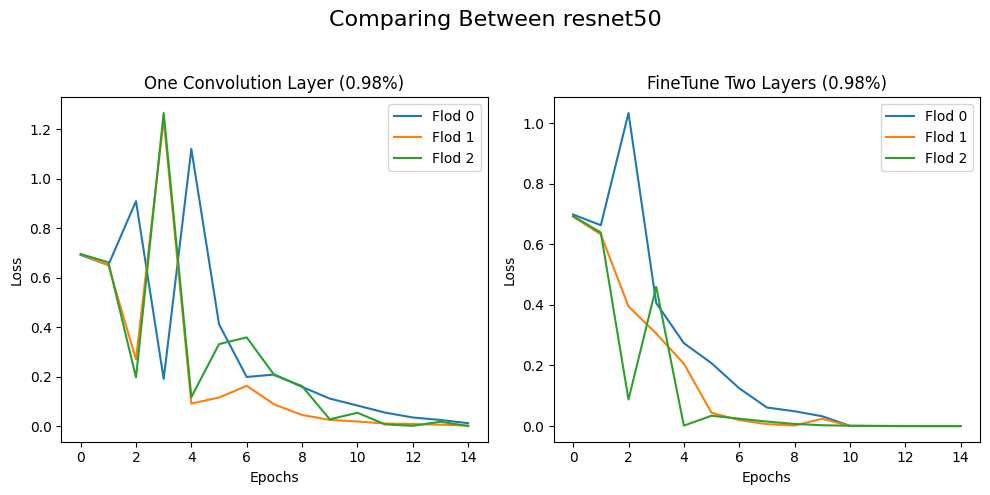

----  resnet50  ---  0.98 %
----------------------- Fake class  {'precision': 0.98, 'recall': 0.98, 'f1-score': 0.98}
----------------------- Real class  {'precision': 0.98, 'recall': 0.98, 'f1-score': 0.98}


----  resnet50_f  ---  0.96 %
----------------------- Fake class  {'precision': 0.9433333333333334, 'recall': 0.98, 'f1-score': 0.96}
----------------------- Real class  {'precision': 0.98, 'recall': 0.94, 'f1-score': 0.96}


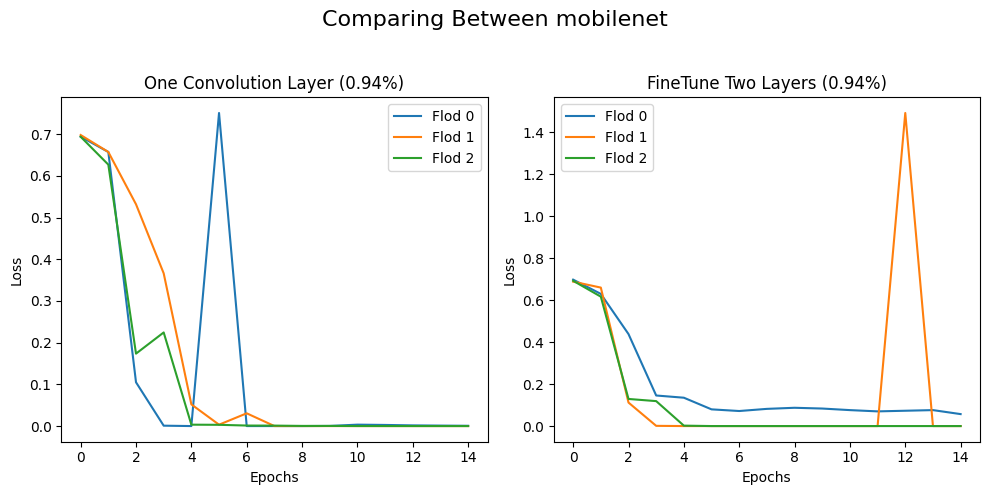

----  mobilenet  ---  0.94 %
----------------------- Fake class  {'precision': 0.9133333333333334, 'recall': 0.98, 'f1-score': 0.9433333333333334}
----------------------- Real class  {'precision': 0.9766666666666667, 'recall': 0.89, 'f1-score': 0.93}


----  mobilenet_f  ---  0.94 %
----------------------- Fake class  {'precision': 0.9166666666666666, 'recall': 0.98, 'f1-score': 0.9466666666666667}
----------------------- Real class  {'precision': 0.98, 'recall': 0.8833333333333333, 'f1-score': 0.9266666666666666}


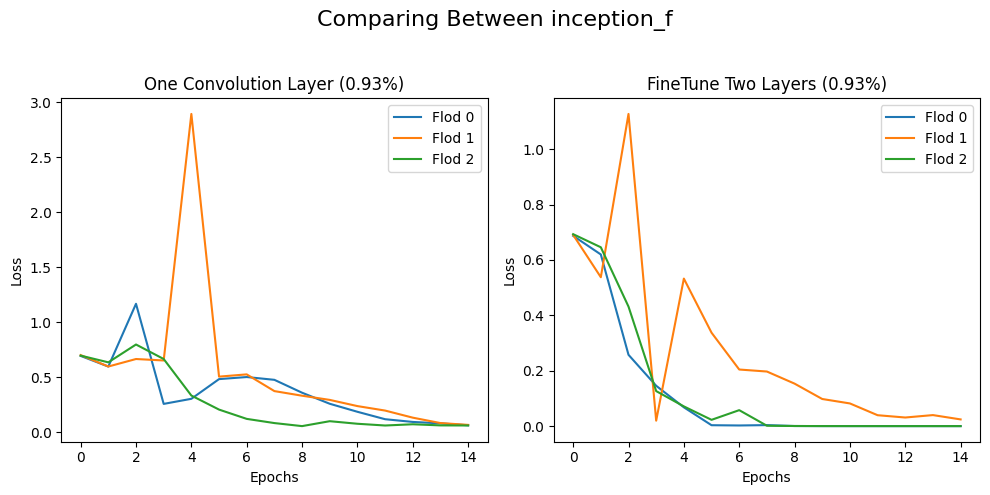

----  inception_f  ---  0.93 %
----------------------- Fake class  {'precision': 0.9, 'recall': 0.98, 'f1-score': 0.9366666666666665}
----------------------- Real class  {'precision': 0.98, 'recall': 0.87, 'f1-score': 0.9199999999999999}


----  efficientnet_b0  ---  0.93 %
----------------------- Fake class  {'precision': 0.9, 'recall': 0.9833333333333334, 'f1-score': 0.9366666666666665}
----------------------- Real class  {'precision': 0.9733333333333333, 'recall': 0.87, 'f1-score': 0.9166666666666666}


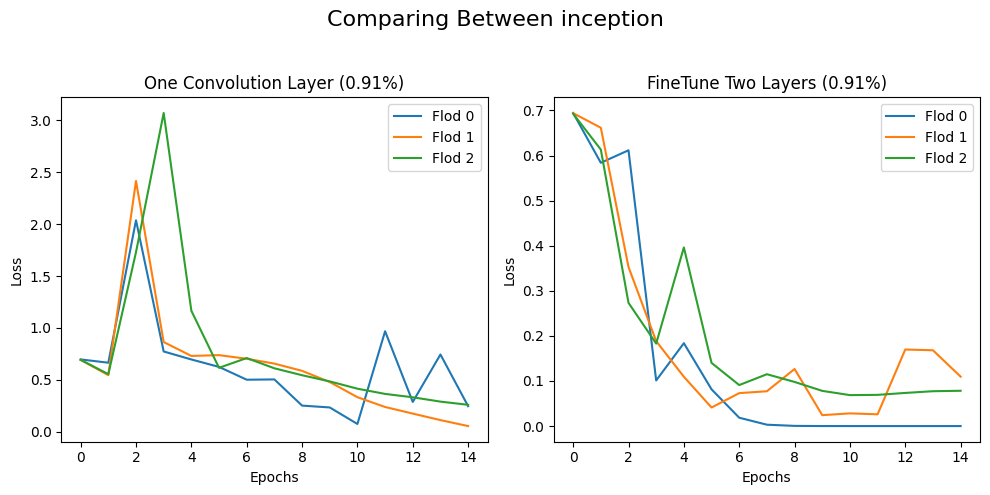

----  inception  ---  0.91 %
----------------------- Fake class  {'precision': 0.86, 'recall': 1.0, 'f1-score': 0.9233333333333333}
----------------------- Real class  {'precision': 1.0, 'recall': 0.8066666666666666, 'f1-score': 0.89}


----  efficientnet_b0_f  ---  0.88 %
----------------------- Fake class  {'precision': 0.8933333333333332, 'recall': 0.89, 'f1-score': 0.8866666666666667}
----------------------- Real class  {'precision': 0.8700000000000001, 'recall': 0.87, 'f1-score': 0.8666666666666667}


In [74]:
for index in np.arange(0,len(model_types),2):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
  for flod_num,history in enumerate(model_details[model_types[index]]):

    y1 =history["loss"]
    x1 = np.arange(len(y1))

    ax1.plot(x1, y1, label="Flod "+str(flod_num))
    ax1.set_title("One Convolution Layer (" + str(round(areport[model_types[index]]["accuracy"],2)) + "%)")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend()

  for flod_num,history in enumerate(model_details[model_types[index+1]]):
    y2 =history["loss"]
    x2 = np.arange(len(y2))

    ax2.plot(x2, y2, label="Flod "+str(flod_num))
    ax2.set_title("FineTune Two Layers (" + str(round(areport[model_types[index]]["accuracy"],2)) + "%)")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Loss")
    ax2.legend()

  fig.suptitle("Comparing Between "+ model_types[index], fontsize=16)

  fig.tight_layout(rect=[0, 0, 1, 0.95])

  plt.show()
  print("---- ",model_types[index]," --- ",areport[model_types[index]]["accuracy"],"%")
  print("----------------------- Fake class ",areport[model_types[index]][0])
  print("----------------------- Real class ", areport[model_types[index]][1])
  print("\n")
  print("---- ",model_types[index+1]," --- ",areport[model_types[index+1]]["accuracy"],"%")
  print("----------------------- Fake class ",areport[model_types[index+1]][0])
  print("----------------------- Real class ", areport[model_types[index+1]][1])



In [73]:
indcies = np.argsort([areport[key]["accuracy"] for key in model_types])[::-1]
model_types = np.array(model_types)[indcies]
print(model_types,"\n----- the best model is: ",model_types[0]," with this accuaracy: ",areport[model_types[0]]['accuracy'])

['resnet50' 'resnet50_f' 'mobilenet' 'mobilenet_f' 'inception_f'
 'efficientnet_b0' 'inception' 'efficientnet_b0_f'] 
----- the best model is:  resnet50  with this accuaracy:  0.98
